## Implementation of an LSP method to automatize the building of a general oncology taxonomy
Main reference:
- Marti A. Hearst. 1992. Automatic Acquisition of Hyponyms from Large Text Corpora. In COLING 1992 Volume 2: The 14th International Conference on Computational Linguistics.

The goal is to implement a pipeline to extract hyponym-hypernym (IS-A) relations from text using the Hearst Patterns method, as described in Marti A. Hearst's paper. We will utilize the scispaCy library, which provides an implementation of the Hearst Patterns through the HyponymDetector component.
Our goal is to build a taxonomy of terms, specifically focusing on cancer-related terms, from a given text corpus.

Some observations:
- Pattern-Based Extraction: We use predefined lexico-syntactic patterns (Hearst Patterns) to extract hyponym-hypernym relations, as described in the paper.
- No Prior Lexical Knowledge: The extraction is done without relying on prior knowledge of specific terms, aligning with the method's goal of - discovering relations directly from text.
- Limitations: As observed in Hearst's paper, the method may extract relations that are too general or context-specific. Post-processing or manual validation may be necessary to refine the taxonomy.
- Automated Acquisition: The pipeline demonstrates automatic acquisition of lexical relations from a corpus, showcasing the practicality of Hearst's approach.

#### Imports
- spacy: An open-source NLP library for advanced natural language processing.
- scispacy: A spaCy extension tailored for scientific and biomedical text processing.
- HyponymDetector: A component from scispacy that implements the Hearst Patterns for hyponym-hypernym extraction.
- networkx: A Python library for creating and manipulating complex networks and graphs.
- matplotlib.pyplot: A plotting library used for visualization.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install scispacy
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_core_sci_sm-0.5.1.tar.gz
!pip install wikipedia-api
!pip install openai==0.28.0
!pip install tiktoken
!pip install rdflib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 kB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.6.1-py2.py3-none-any.whl.metadata (8.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 6.3 MB/s eta 0:00:00
Using cached pybind11-2.6.1-py2.py3-none-any.whl (188 kB)
  Created wheel for nmslib: filename=nmslib-2.1.1-cp310-cp310-linux_x86_64.whl size=13547969 sha256=77ca264e38bf64603c16c2d7ddb41735e536526082e338cacc6ea0c5ab304faa
  Stored in directory: /root/.cache/pip/wheels/21/1a/5d/4cc754a5b1a88405cad184b76f823897a63a8d19afcd4b9314
Successfully built nmslib
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 16.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.6/152.6 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 87.1 MB/s eta 0:00:00
   ━━━━━━━━━━

In [3]:
import sys
sys.path.append('/content/drive/MyDrive/thesis')

In [4]:
import spacy
from spacy.matcher import Matcher
import networkx as nx
import matplotlib.pyplot as plt

## Setting up the Scispacy model

This cell sets up our spaCy NLP pipeline to process biomedical text. It is useful mostly in the filtering step to decide which relationships between cancer terms (hyponyms and hypernyms) are medically valid. It helps ensure that only relevant and meaningful entities are included in the taxonomy by checking against the UMLS database and resolving abbreviations.

- Loading the **en_core_sci_sm** model, which is a lightweight language model designed for scientific and biomedical texts. This model helps with tokenization, tagging parts of speech, and **identifying entities such as diseases or treatments in the text.**

- **AbbreviationDetector**: This tool is added to the pipeline to find abbreviations in the text and links them to their full forms. For example, if "AML" appears in the text, it will identify that it stands for "Acute Myeloid Leukemia." This is especially helpful because cancer-related texts often use many abbreviations.

- **EntityLinker**: This tool takes the entities identified in the text and links them to a database of medical knowledge called UMLS (Unified Medical Language System). It matches the entities with standardized concepts, providing additional information and ensuring consistency.


In [5]:
# Load the spaCy model and add the HyponymDetector to the pipeline
from scispacy.linking import EntityLinker
from scispacy.abbreviation import AbbreviationDetector

nlp = spacy.load("en_core_sci_sm")
nlp.add_pipe("abbreviation_detector", last=True)
nlp.add_pipe("scispacy_linker", config={"resolve_abbreviations": True, "linker_name": "umls"})

https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linkers/2023-04-23/umls/tfidf_vectors_sparse.npz not found in cache, downloading to /tmp/tmp90vmc2cg


100%|██████████| 492M/492M [00:41<00:00, 12.6MiB/s]


Finished download, copying /tmp/tmp90vmc2cg to cache at /root/.scispacy/datasets/2b79923846fb52e62d686f2db846392575c8eb5b732d9d26cd3ca9378c622d40.87bd52d0f0ee055c1e455ef54ba45149d188552f07991b765da256a1b512ca0b.tfidf_vectors_sparse.npz
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linkers/2023-04-23/umls/nmslib_index.bin not found in cache, downloading to /tmp/tmpjzu334zr


100%|██████████| 724M/724M [00:43<00:00, 17.6MiB/s]


Finished download, copying /tmp/tmpjzu334zr to cache at /root/.scispacy/datasets/7e8e091ec80370b87b1652f461eae9d926e543a403a69c1f0968f71157322c25.6d801a1e14867953e36258b0e19a23723ae84b0abd2a723bdd3574c3e0c873b4.nmslib_index.bin
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linkers/2023-04-23/umls/tfidf_vectorizer.joblib not found in cache, downloading to /tmp/tmpv_sxh0in


100%|██████████| 1.32M/1.32M [00:00<00:00, 1.64MiB/s]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.1.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Finished download, copying /tmp/tmpv_sxh0in to cache at /root/.scispacy/datasets/37bc06bb7ce30de7251db5f5cbac788998e33b3984410caed2d0083187e01d38.f0994c1b61cc70d0eb96dea4947dddcb37460fb5ae60975013711228c8fe3fba.tfidf_vectorizer.joblib


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.1.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linkers/2023-04-23/umls/concept_aliases.json not found in cache, downloading to /tmp/tmpkde0zqur


100%|██████████| 264M/264M [00:15<00:00, 17.7MiB/s]


Finished download, copying /tmp/tmpkde0zqur to cache at /root/.scispacy/datasets/6238f505f56aca33290aab44097f67dd1b88880e3be6d6dcce65e56e9255b7d4.d7f77b1629001b40f1b1bc951f3a890ff2d516fb8fbae3111b236b31b33d6dcf.concept_aliases.json
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/kbs/2023-04-23/umls_2022_ab_cat0129.jsonl not found in cache, downloading to /tmp/tmpenl2g9dg


100%|██████████| 628M/628M [00:36<00:00, 18.3MiB/s]


Finished download, copying /tmp/tmpenl2g9dg to cache at /root/.scispacy/datasets/d5e593bc2d8adeee7754be423cd64f5d331ebf26272074a2575616be55697632.0660f30a60ad00fffd8bbf084a18eb3f462fd192ac5563bf50940fc32a850a3c.umls_2022_ab_cat0129.jsonl
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/umls_semantic_type_tree.tsv not found in cache, downloading to /tmp/tmp9_6tqzez


100%|██████████| 4.26k/4.26k [00:00<00:00, 3.59MiB/s]

Finished download, copying /tmp/tmp9_6tqzez to cache at /root/.scispacy/datasets/21a1012c532c3a431d60895c509f5b4d45b0f8966c4178b892190a302b21836f.330707f4efe774134872b9f77f0e3208c1d30f50800b3b39a6b8ec21d9adf1b7.umls_semantic_type_tree.tsv


In [6]:
from src.corpus.extract_wiki_corpus import extract_cancer_articles, save_corpus
from src.corpus.format_corpus import format_large_text
from src.extraction.extract import extract_hyponyms
from src.extraction.filter import filter_relations
from src.extraction.postprocess import rearrange_taxonomy_pairs
from src.extraction.filter import filter_relations_by_umls_medical
from src.taxonomy.build_taxonomy import build_taxonomy
from src.taxonomy.visualize_taxonomy import visualize_taxonomy
from src.taxonomy.export_to_rdf import export_to_rdf

## Corpus extraction
- The corpus used in this pipeline (for now) consists of cancer-related articles extracted from Wikipedia. It includes text on topics such as general cancer types (e.g., carcinoma, sarcoma, leukemia), specific cancers (e.g., breast cancer, lung cancer, prostate cancer), and broader concepts like oncology, tumors, and metastasis.
For now, the corpus is composed of

- The processing pipeline also incorporates a prompting process to an LLM, to address a key challenge: the unstructured nature of the raw corpus extracted from Wikipedia. Without this processing step, the corpus lacks the necessary structure and coherence, making it difficult for the Hearst method to reliably identify LSPs since it operates purely on syntactic cues without semantic understanding. The raw text often contains unrelated information, poorly formed sentences, and inconsistent phrasing, leading to a messy and fragmented taxonomy. By using an LLM, the corpus is refined to keep the sentences containing specific LSPs (e.g., "X such as Y," "Y including X"), and filter irrelevant content.

- This preprocessing step is expected to enhance the quality and clarity of the resulting taxonomy, ensuring that the Hearst method can effectively extract meaningful hierarchical relationships.

In [7]:
# Define file paths for raw and formatted corpus
raw_corpus_path = "/content/drive/MyDrive/thesis/data/cancer_corpus.txt"
formatted_corpus_path = "/content/drive/MyDrive/thesis/data/formatted_cancer_corpus.txt"


In [ ]:
# Step 1: Extract Wikipedia articles on cancer
print("Extracting cancer articles from Wikipedia...")
cancer_articles = extract_cancer_articles()

# Step 2: Save raw corpus to a file
print("Saving raw cancer corpus to data directory...")
save_corpus(cancer_articles, file_path=raw_corpus_path)

# Step 3: Format the text using prompting to GPT-3.5-turbo
print("Formatting the text corpus...")
with open(raw_corpus_path, "r", encoding="utf-8") as f:
    raw_text = f.read()

formatted_corpus = format_large_text(raw_text)

# Step 4: Save the formatted corpus
print("Saving formatted corpus to data directory...")
with open(formatted_corpus_path, "w", encoding="utf-8") as f:
    f.write(formatted_corpus)

print("Text extraction and formatting completed!")

In [8]:
# Step 1: Load the formatted corpus
print("Loading formatted text corpus...")
with open(formatted_corpus_path, "r", encoding="utf-8") as f:
    formatted_corpus = f.read()

Loading formatted text corpus...


## Building the taxonomy using LSPs
### Step 1: Extract Hyponym-Hypernym Relations
* **Function:** extract_hyponym(formatted_corpus, nlp)
* **Purpose:** This function identifies hyponym-hypernym relationships (e.g., "lung cancer" is a type of "cancer") from the formatted corpus using predefined lexico-syntactic patterns:

### Step 2: Filter relations to keep Longest terms
* **Function:** filter_relations(hyponym_relations)
* **Purpose:** This function refines the raw hyponym-hypernym relationships by removing shorter or redundant terms. For example, if the input is:

```python
[
    ("non-small cell lung cancer", "lung cancer", "such_as"),
    ("small-cell lung cancer", "lung cancer", "such_as")
]
```
The output should be:
```python
[
    ("non-small cell lung cancer", "lung cancer", "such_as")
]
```

The same filtering is done for hypernyms

### Step 3: Filter relations using UMLS
* **Function:** filter_relations_by_umls_medical(hyponym_relations_filtered, nlp)
* **Purpose:** This step uses the spaCy NLP pipeline with the UMLS linker to validate the hyponym-hypernym pairs against a biomedical knowledge base. It filters out relationships involving terms that are not medically relevant or linked to excluded types (e.g., concepts like geographic locations or abstract ideas). Since UMLS includes many subject, we try to remove some identified themes that are not relevant for our study, in the "EXCLUDED_TYPES" variable.

### Step 4: Post-Process and Rearrange Relations
* **Function:** rearrange_taxonomy_pairs(filtered_hyponym_relations)

* **Purpose:** This function uses prompting to GPT-3.5-turbo to refine and reorganize the filtered hyponym-hypernym pairs into a consistent and hierarchical structure.
It is expected to:
  * Rearrange the relations so that the resulting taxonomy descend from the top-level concept "cancer"
  * Consolidate variants (e.g., plurals).
  * Remove remaining redundancies, resolve conflicting relationships, and fill in missing links to create a coherent hierarchy.
Here's the prompt used:

```python
# Prompt for the LLM
    prompt = f"""
    You are given a list of hyponym-hypernym relationships extracted from a cancer taxonomy.
    Each relationship is represented as a tuple (hyponym, hypernym, relation).

    Your task:
    1. Ensure every cancer-related class (e.g., leukemia, sarcoma, lung cancer, skin cancer)
       directly or indirectly descends from "cancer". If not, add or adjust relationships.
    2. Normalize classes: merge plurals and variants into a single canonical form ("cancers" → "cancer").
    3. Remove or fix unrelated or incorrect pairs.
    4. Add missing relationships as needed to maintain a coherent hierarchy.
    5. Return the final list as a valid Python list of tuples.

    ### Input Pairs:
    {input_pairs_str}

    ### Output Pairs:
    Return the updated pairs as a Python list of tuples:
    """
```

### Step 5: Build the Taxonomy Graph
* **Function: **build_taxonomy(post_processed_relations)
* **Purpose:** This function creates a directed graph where nodes represent terms (e.g., "lung cancer," "cancer") and edges represent hyponym-hypernym relationships. It also computes transitive relationships to connect indirectly related terms.


### Step 6: Visualize the Taxonomy
* **Function Used:** visualize_taxonomy(G)
Purpose: This step visually represents the taxonomy graph, differentiating between direct relationships (e.g., "lung cancer" → "cancer") and transitive relationships (e.g., "non-small cell lung cancer" → "cancer").

* **Why Important:** Visualization provides an intuitive way to understand the structure of the taxonomy, highlighting key relationships and overall organization.

/usr/local/lib/python3.10/dist-packages/scispacy/abbreviation.py:248: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  global_matches = self.global_matcher(doc)


[('small cell carcinoma', 'cell carcinoma', 'ends_with'), ('merkel cell carcinoma', 'cell carcinoma', 'ends_with'), ('basal cell carcinoma', 'cell carcinoma', 'ends_with'), ('large-cell carcinoma', 'cell carcinoma', 'ends_with'), ('squamous-cell carcinoma', 'cell carcinoma', 'ends_with'), ('squamous cell carcinoma', 'cell carcinoma', 'ends_with'), ('transitional cell carcinoma', 'cell carcinoma', 'ends_with'), ('renal cell carcinoma', 'cell carcinoma', 'ends_with'), ('renal cell carcinoma', 'complex epithelial neoplasms', 'including'), ('basal cell skin cancer . "', 'superficial cancers', 'like'), ('human history', 'history', 'ends_with'), ('grawitz tumor . "', 'complex epithelial neoplasms', 'including'), ('large-cell carcinomas . "', 'non-small cell lung cancers', 'such_as'), ('squamous-cell carcinomas', 'non-small cell lung cancers', 'such_as'), ('adenocarcinomas', 'non-small cell lung cancers', 'such_as'), ('radiation-induced leukemia . "', 'body', 'including'), ('chronic myelomono

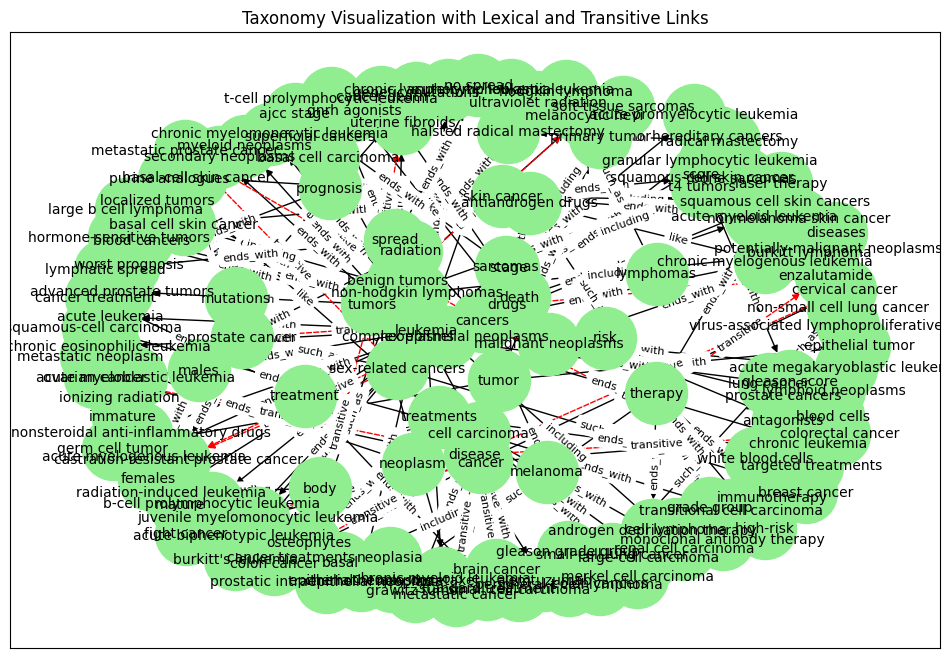

In [10]:
# Step 1: Extract hyponym relations
hyponym_relations = extract_hyponyms(formatted_corpus, nlp)

# Step 2: Filter hyponym relations to keep only the longest hyponyms and hypernyms
hyponym_relations_filtered = filter_relations(hyponym_relations)

# Step 3: Filter the hyponym relations using UMLS
filtered_hyponym_relations = filter_relations_by_umls_medical(hyponym_relations_filtered, nlp)
print(filtered_hyponym_relations)

post_processed_relations = rearrange_taxonomy_pairs(filtered_hyponym_relations)
print(post_processed_relations)
# Step 4: Build the taxonomy graph
G = build_taxonomy(post_processed_relations)

# Step 5: Print and visualize the taxonomy
print("Hyponym Relations with Lexical Links:")
for hyponym, hypernym, relation_label in post_processed_relations:
    print(f"hyponym('{hyponym}', '{hypernym}') - relation: '{relation_label}'")

visualize_taxonomy(G)



## Export extracted ontology in RDF format
This step is important to be able to use metrics like F1 to compare the extracted taxonomy, to the chosen benchmark (NCIt taxonomy, everything that descends from "Neoplasm by Site")

In [11]:
export_to_rdf(G, output_file="/content/drive/MyDrive/thesis/results/symbolic_taxonomy.rdf")

RDF file with sanitized URIs saved to /content/drive/MyDrive/thesis/taxonomy.rdf


## Old

### Assess the themes to remove from UMLS

In [ ]:
# Sample text containing cancer-related and non-cancer-related sentences
text_1 = """
Cancers such as carcinomas are hard.
Carcinomas such as basal cell carcinoma, squamous cell carcinoma, and adenocarcinoma are common
Leukemia, including acute lymphoblastic leukemia and chronic lymphocytic leukemia, affects the blood and bone marrow.
There are many types of sarcomas, especially osteosarcoma and chondrosarcoma.
Germ cell tumors, such as seminoma and teratoma, originate from germ cells.
Lymphomas, including Hodgkin lymphoma and non-Hodgkin lymphoma, affect the lymphatic system.
Some cancers, like pancreatic cancer, lung cancer, or other deadly diseases, have high mortality rates.
Tumors, especially malignant ones like glioblastoma and astrocytoma, are dangerous.
Breast cancers, including ductal carcinoma and lobular carcinoma, are common in women.
The study explores non-cancerous conditions such as diabetes, hypertension, and other metabolic disorders.
Advancements in technology such as artificial intelligence and machine learning are transforming healthcare.
"""

In [ ]:
# Access the linker from the pipeline
linker = nlp.get_pipe("scispacy_linker")

# Analyze the UMLS linking for hyponyms and hypernyms
hyponym_doc = nlp("machine learning")
hypernym_doc = nlp("technology")

print("Hyponym UMLS Linking:")
for ent in hyponym_doc.ents:
    print(f"Entity: {ent.text}")
    for cui, score in ent._.kb_ents:
        entity = linker.kb.cui_to_entity[cui]
        print(f"  - CUI: {cui}, Name: {entity.canonical_name}, Semantic Types: {entity.types}")

print("\nHypernym UMLS Linking:")
for ent in hypernym_doc.ents:
    print(f"Entity: {ent.text}")
    for cui, score in ent._.kb_ents:
        entity = linker.kb.cui_to_entity[cui]
        print(f"  - CUI: {cui}, Name: {entity.canonical_name}, Semantic Types: {entity.types}")

